# Description of the code: 

### 1. Load the video  
It can be a tiff video file or a folder containing tiff images. Other fromats are possible but require to adapt the code line that converts the video into a numpy array. 
### 2. Specify the camera framerate
Units: Hz
### 3. Choose a downscaling parameter to speed the computation
### 4. Choose a thresholding method
### 5. Select the fit range
First and last frame to use for the fit
### 6. Assess that there is no saturated pixels
### 7. Run the pixel-per-pixel fit
### 8. Display the result
### 9. Load the raw data for visualisation with the code "display_curves.ipynb"

### **Instructions to run the code can be found [here](https://github.com/DreamRepo/light_calibration#usage)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click


import incense
from incense import ExperimentLoader

#source: incense github page

def get_mongo_uri():
    in_devcontainer = (
        os.environ.get("TERM_PROGRAM") == "vscode"
        or os.environ.get("HOME") == "/home/vscode"
        or (os.environ.get("PATH") or "").startswith("/home/vscode")
    )
    if in_devcontainer:
        return "mongodb://mongo:27017"
    else:
        return None



loader = ExperimentLoader(
    mongo_uri=get_mongo_uri(), 
    db_name='sacred'
)

#%matplotlib widget

In [2]:
idi = 464
exp = loader.find_by_id(idi)
video = tiff.imread(exp.artifacts["video.tiff"].file)

In [3]:
video.shape

(147, 1216, 1936)

percent of saturated pixels in the mask:  0.0


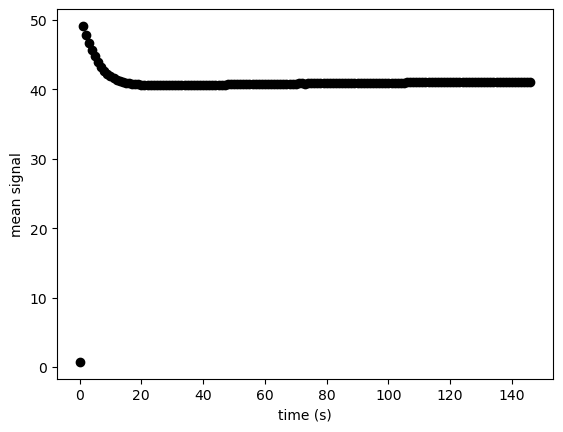

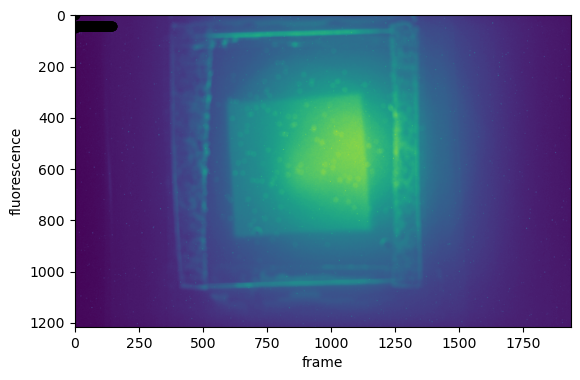

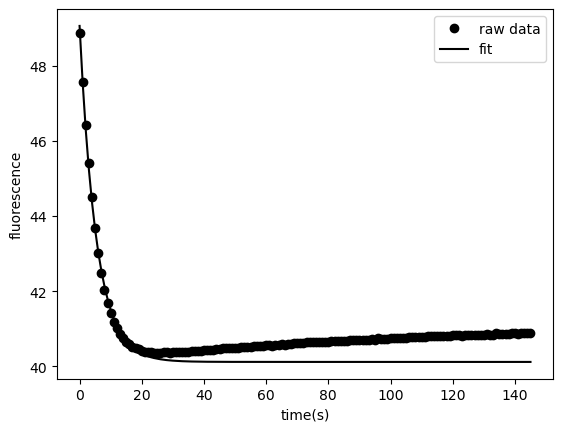

In [4]:

save_folder = glob.glob("C:/Users/alien/Documents/Github/CSL-forge/Experiments/%d_*"%idi)[0]
timing = exp.metrics["Time"]

framerate = 1/(timing[1]-timing[0])

plt.xlabel('time (s)')
plt.ylabel('mean signal')
plt.plot(timing, np.mean(video[0:], axis = (1,2)), "ko")
plt.figure()

slices = np.mean(video, axis = (1,2))
frames = video[slices>np.quantile(slices, 0.8)]
frame_ref = np.mean(frames, axis =0)
plt.imshow(frame_ref)

D = 5
D_image = downscale_local_mean(frame_ref, (D,D))

#downscaling 
video_downscaled = []
for i in range(0, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]



#FILTER
#u = skimage.filters.try_all_threshold(D_image)
#threshold_method = threshold_convert(click.prompt("copy the name of the thresholding method that suits you (no caps). If none suits, enter None", type = str, default="minimum"))
threshold_method = threshold_convert("None")

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
threshold = threshold_method(D_image)

mask = D_image>threshold

video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

plt.plot(np.mean(to_evaluate, axis = 1), 'ok')
plt.xlabel('frame')
plt.ylabel('fluorescence')


start = 1
stop = len(to_evaluate)


#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)

time = timing[start:stop]
time -= time[0]
plt.figure()
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
plt.plot(time, exp_decay(params, time), "k", label = "fit")
plt.xlabel('time(s)')
plt.ylabel("fluorescence")
plt.legend()
plt.savefig(save_folder + "/" + "mean_decay_fit_D2.png")


sat = np.sum(to_evaluate[0]==255)/len(to_evaluate[0].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")
 

In [5]:
   
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|███████████████████████████████████████| 94672/94672 [03:19<00:00, 474.04it/s]


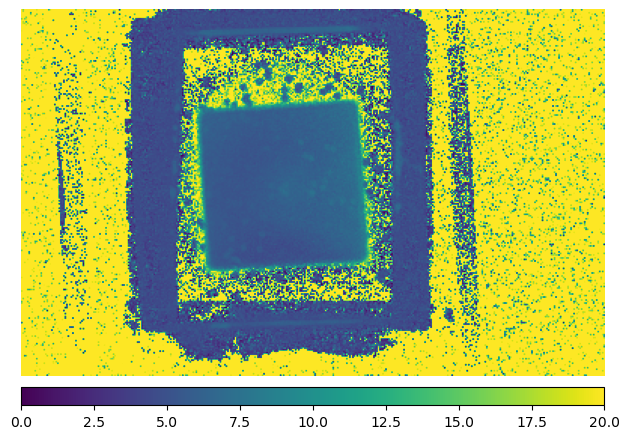

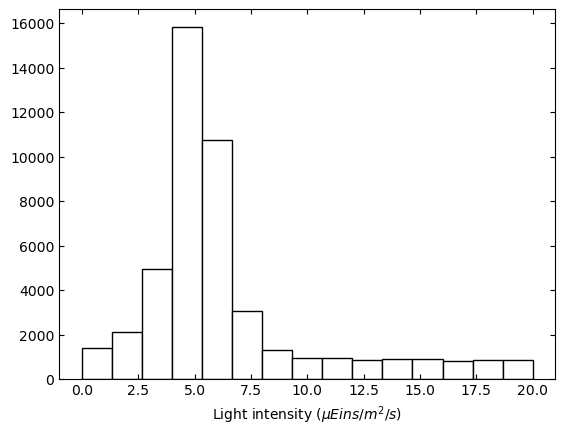

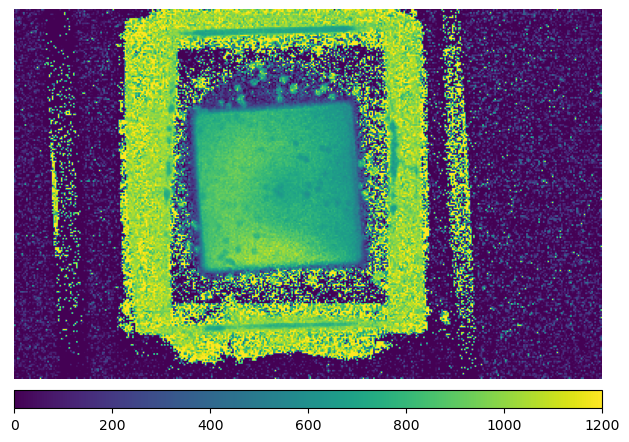

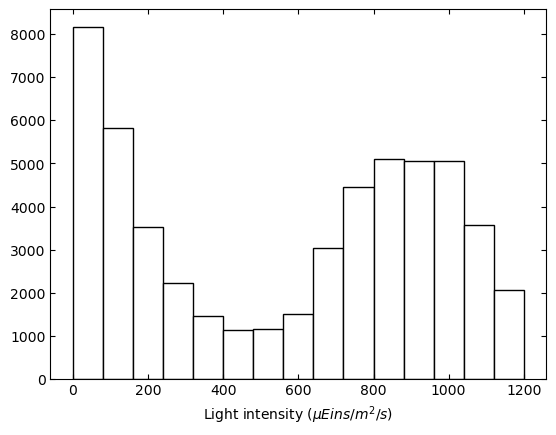

In [6]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save(save_folder + "/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'

dd, uu = plot_map(tau_480, tau_480_map, save_folder + "/tau_480_map_B", limits = (0,20))
 
I, dis = plot_map(I_480, I_480_map, save_folder + "/I_480_map_B" + extension, limits = (0, 1200))

np.save(save_folder + "/video_2D.npy", video_2D[start:stop])
np.save(save_folder + "/framerate.npy", framerate)


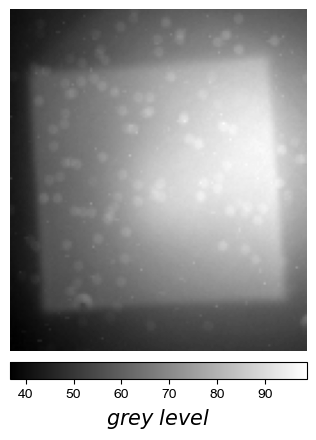

In [16]:
image = plt.imshow(D_image[40:190,110:240], cmap = "gray")
plt.axis("off")
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
plt.xlabel("$grey$ $level$", size = 15)

plt.savefig('results/grey_map_ENS' + extension, bbox_inches = 'tight')

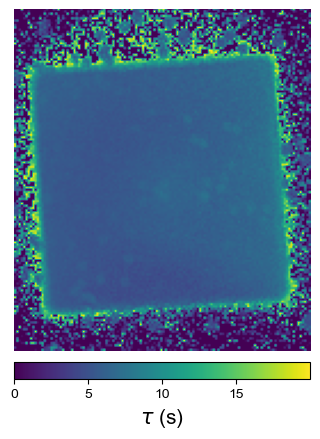

In [17]:
loc_im = tau_480_map[40:190,110:240]
loc_im[loc_im==loc_im.max()] = loc_im.min()
image = plt.imshow(loc_im, cmap = "viridis")#[58:177,118:232])
plt.axis("off")
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
plt.xlabel(r"$\tau$ (s)", size = 15)
plt.savefig('results/tau_map_ENS' + extension, bbox_inches = 'tight')

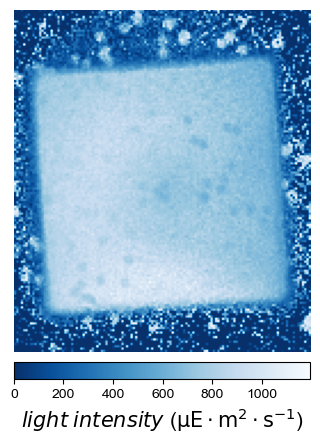

In [18]:
loc_im = I_480_map[40:190,110:240]
loc_im[loc_im==loc_im.max()] = loc_im.min()
image = plt.imshow(I_480_map[40:190,110:240], cmap = "Blues_r")#[58:177,118:232])
plt.axis("off")
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
plt.xlabel(r"$light$ $intensity$ ($\mathrm{\mu E \cdot m^2 \cdot s^{-1}}$)", size = 15)
plt.savefig('results/intensity_map_ENS' + extension, bbox_inches = 'tight')

In [10]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def set_figure(formatx = "%0.1e", formaty = "0.1e", figsize = (10,10)):
    inch = 2.35
    fig, ax = plt.subplots(figsize = (figsize[0]/inch, figsize[1]/inch))
    
    rc = {"font.family" : "Arial", 
          "mathtext.fontset" : "dejavusans",
          "axes.labelsize":15,
         "axes.labelsize":12}
    
    plt.rcParams.update(rc)

    
    formatx = FormatStrFormatter(formatx)
    formaty = FormatStrFormatter(formaty)

    ax.xaxis.set_major_formatter(formatx)
    ax.yaxis.set_major_formatter(formaty)
    
    return fig, ax



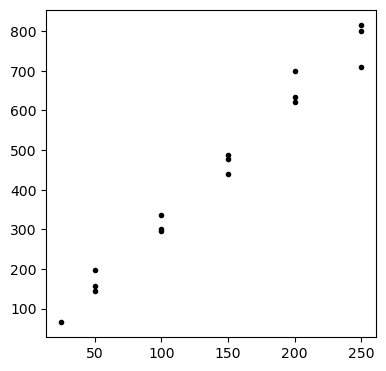

In [11]:
fig, ax = set_figure("%d", "%d")
clean = [231, 232, 234, 239, 240, 242, 244, 245, 246, 247, 248,249]
dirty = [235, 236, 237, 238]
for idi in clean + dirty:#[218, 219, 220, 221, 222]:
    exp = loader.find_by_id(idi)
    x = exp.metrics['Time']
    y = exp.metrics['Fluorescence'].values
    conv = np.mean(y[-10:])
    #if idi in clean:
    #    plt.plot(x, (y-conv)/(y[0]-conv))
    params = simple_tau(y, x, sample_rate = framerate)
    
    intensity = exp.config.arduino_LED.blue_param.analog_value
    ax.plot(intensity, 1e6/(sigma_480*params[1]), '.k')
#plt.ylabel(r'Intensity ($\mu$E $\dot$')#m$^2$\dot ')#s$^{-1^}$)')

In [12]:
t

NameError: name 't' is not defined